# Lambert W x Gamma Regression (California Housing Data)

This is in comparison to the Gamma Regression notebook for the same dataset.  The Lambert W x Gamma distribution adds an additional tail parameter for adding heavier weight to larger values in the target variable (compared to what a Gamma distribution could afford).

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/StatMixedML/XGBoostLSS/blob/master/docs/examples/Gamma_Regression_CaliforniaHousing.ipynb)

# Imports

In [1]:
from xgboostlss.model import *
from xgboostlss.distributions.Weibull import *
from xgboostlss.distributions.LambertWGamma import *
from xgboostlss.distributions.LambertWWeibull import *


from sklearn import datasets
from sklearn.model_selection import train_test_split
import multiprocessing
import seaborn as sns

# Data

In [2]:
n_cpu = multiprocessing.cpu_count()
print(n_cpu)
housing_data = datasets.fetch_california_housing()
X, y = housing_data["data"], housing_data["target"]
feature_names = housing_data["feature_names"]

8


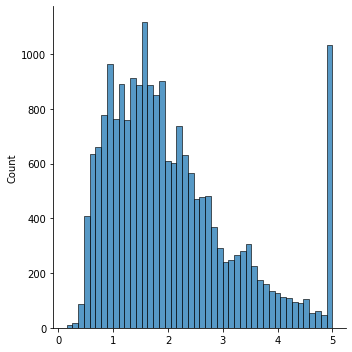

In [3]:
sns.displot(y)

5.0
(20640, 8)
(19648, 8)


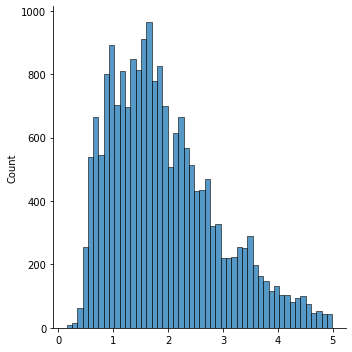

In [4]:
cutoff_value_y = 5.0
mask = (y < cutoff_value_y)
print(cutoff_value_y)
print(X.shape)
y = y[mask]
X = X[mask]
print(X.shape)
sns.displot(y)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

dtrain = xgb.DMatrix(X_train, label=y_train, nthread=n_cpu - 1)
dtest = xgb.DMatrix(X_test, nthread=n_cpu)

# Distribution Selection

In [55]:
# Specifies Gamma distribution with exp response function and option to stabilize Gradient/Hessian. Type ?Gamma for an overview.
xgblss = XGBoostLSS(
     SkewLambertWGamma(stabilization="L2",     # Options are "None", "MAD", "L2".
          response_fn="exp",      # Function to transform the concentration and rate parameters, e.g., "exp" or "softplus".
          loss_fn="nll"           # Loss function. Options are "nll" (negative log-likelihood) or "crps"(continuous ranked probability score).
         )
)

# Hyper-Parameter Optimization

Any XGBoost hyperparameter can be tuned, where the structure of the parameter dictionary needs to be as follows:

    - Float/Int sample_type
        - {"param_name": ["sample_type", low, high, log]}
            - sample_type: str, Type of sampling, e.g., "float" or "int"
            - low: int, Lower endpoint of the range of suggested values
            - high: int, Upper endpoint of the range of suggested values
            - log: bool, Flag to sample the value from the log domain or not
        - Example: {"eta": "float", low=1e-5, high=1, log=True]}

    - Categorical sample_type
        - {"param_name": ["sample_type", ["choice1", "choice2", "choice3", "..."]]}
            - sample_type: str, Type of sampling, either "categorical"
            - choice1, choice2, choice3, ...: str, Possible choices for the parameter
        - Example: {"booster": ["categorical", ["gbtree", "dart"]]}

    - For parameters without tunable choice (this is needed if tree_method = "gpu_hist" and gpu_id needs to be specified)
        - {"param_name": ["none", [value]]},
            - param_name: str, Name of the parameter
            - value: int, Value of the parameter
        - Example: {"gpu_id": ["none", [0]]}

Depending on which parameters are optimized, it might happen that some of them are not used, e.g., when {"booster":  ["categorical", ["gbtree", "gblinear"]]} and {"max_depth": ["int", 1, 10, False]} are specified, max_depth is not used when gblinear is sampled, since it has no such argument.

In [ ]:
param_dict = {
    "eta":              ["float", {"low": 0.0001,   "high": 0.1,     "log": True}],
    "max_depth":        ["int",   {"low": 2,      "high": 5,    "log": False}],
    "gamma":            ["float", {"low": 0.01,   "high": 1,    "log": True}],
    "subsample":        ["float", {"low": 0.75,    "high": 1.0,   "log": False}],
    "colsample_bytree": ["float", {"low": 0.75,    "high": 1.0,   "log": False}],
    "min_child_weight": ["float", {"low": 5,   "high": 20,   "log": True}],
    "booster":          ["categorical", ["gbtree"]],
    # "tree_method":    ["categorical", ["auto", "approx", "hist", "gpu_hist"]],
    # "gpu_id":         ["none", [0]]
}

np.random.seed(123)
opt_param = xgblss.hyper_opt(param_dict,
                             dtrain,
                             num_boost_round=100,        # Number of boosting iterations.
                             nfold=2,                    # Number of cv-folds.
                             early_stopping_rounds=20,   # Number of early-stopping rounds
                             max_minutes=10,              # Time budget in minutes, i.e., stop study after the given number of minutes.
                             n_trials=10,              # The number of trials. If this argument is set to None, there is no limitation on the number of trials.
                             silence=False,              # Controls the verbosity of the trail, i.e., user can silence the outputs of the trail.
                             seed=123,                   # Seed used to generate cv-folds.
                             hp_seed=5                # Seed for random number generator used in the Bayesian hyperparameter search.
                            )

# Model Training

In [81]:
# Copied from Gamma_Regression_CaliforniaHousing results
opt_params = {'eta': 0.006828458758181937, 'max_depth': 3, 'gamma': 0.02867220804180919, 'subsample': 0.7449033258369016, 'colsample_bytree': 0.7501074528745713, 'min_child_weight': 9.969409715145769, 'booster': 'gbtree'}

In [57]:
np.random.seed(123)

#opt_params = opt_param.copy()
#n_rounds = opt_params["opt_rounds"]
#del opt_params["opt_rounds"]

# Train Model with optimized hyperparameters
xgblss.train(opt_params,
             dtrain,
             num_boost_round=n_rounds
             )

# Prediction

In [58]:
# Set seed for reproducibility
torch.manual_seed(123)

# Number of samples to draw from predicted distribution
n_samples = 1000
quant_sel = [0.05, 0.5, 0.95] # Quantiles to calculate from predicted distribution

# Sample from predicted distribution
pred_samples = xgblss.predict(dtest,
                              pred_type="samples",
                              n_samples=n_samples,
                              seed=123)

# Calculate quantiles from predicted distribution
pred_quantiles = xgblss.predict(dtest,
                                pred_type="quantiles",
                                n_samples=n_samples,
                                quantiles=quant_sel)

# Returns predicted distributional parameters
pred_params = xgblss.predict(dtest,
                             pred_type="parameters")

In [59]:
pred_samples.head()

,y_sample0,y_sample1,y_sample2,y_sample3,y_sample4,y_sample5,y_sample6,y_sample7,y_sample8,y_sample9,...,y_sample990,y_sample991,y_sample992,y_sample993,y_sample994,y_sample995,y_sample996,y_sample997,y_sample998,y_sample999
0,1.035468,1.093924,0.540763,0.744385,0.826902,0.543085,0.447485,1.319410,0.665407,0.302960,...,1.458644,0.817056,0.861458,0.742869,1.861265,1.967130,1.199203,0.672559,1.316955,0.758526
1,2.579023,1.962349,4.610039,2.401588,1.534667,1.956301,1.483845,2.400766,3.401317,1.422182,...,1.001038,1.045983,1.500136,1.891830,1.446964,3.091578,1.903271,2.072961,2.392117,1.067012
2,0.821330,1.189566,0.977001,1.887025,0.763401,1.208061,1.261087,1.085487,0.528172,2.714929,...,1.169296,1.863099,0.757787,0.522731,1.525388,2.530915,3.102011,1.811730,2.595166,1.241984
3,2.273950,4.877029,0.983636,2.166917,1.876778,0.801598,1.880138,2.815810,1.000775,2.197690,...,1.430203,2.302006,2.005729,2.973656,3.605642,5.346694,2.681543,1.351781,1.938143,1.451398
4,1.921394,1.445985,1.211931,0.881405,0.694436,2.324336,1.972977,1.301429,2.672181,1.306114,...,3.262377,1.714447,2.089332,0.453814,0.770693,2.318048,2.935801,0.860983,1.645182,1.166701


In [60]:
pred_quantiles.head()

,quant_0.05,quant_0.5,quant_0.95
0,0.348076,1.098421,2.493601
1,1.005910,2.441229,4.994035
2,0.632005,1.610773,3.445941
3,0.812950,1.995756,4.375545
4,0.662716,1.621415,3.477172


In [61]:
pred_quantiles.head()

,quant_0.05,quant_0.5,quant_0.95
0,0.348076,1.098421,2.493601
1,1.005910,2.441229,4.994035
2,0.632005,1.610773,3.445941
3,0.812950,1.995756,4.375545
4,0.662716,1.621415,3.477172


In [62]:
pred_params.head()

,concentration,rate,skewweight
0,3.568131,3.068008,0.027690
1,5.289053,2.175107,0.030948
2,4.372138,2.577450,0.018033
3,4.866154,2.380687,0.035718
4,4.252453,2.492586,0.018484


In [63]:
pred_params.head()

,concentration,rate,skewweight
0,3.568131,3.068008,0.027690
1,5.289053,2.175107,0.030948
2,4.372138,2.577450,0.018033
3,4.866154,2.380687,0.035718
4,4.252453,2.492586,0.018484


In [64]:
pred_params["median"] = pred_quantiles["quant_0.5"]
pred_params["mean"] = pred_samples.mean(axis=1)
pred_params["scale"] = 1. / pred_params["rate"]
# Gamma
pred_params["mean_latent"] = pred_params["concentration"] / pred_params["rate"]
pred_params["var"] = pred_params["mean"] / pred_params["rate"]

# Weibull
import scipy.special
#pred_params["mean_latent"] = pred_params["scale"] * scipy.special.gamma(1. + 1 / pred_params["concentration"])# / pred_params["rate"]


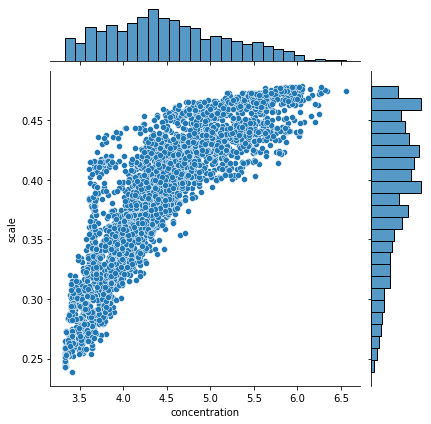

In [65]:
sns.jointplot(data=pred_params, x="concentration", y="scale")

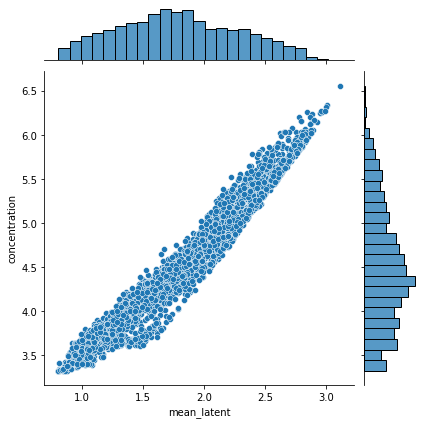

In [79]:
sns.jointplot(data=pred_params, x="mean_latent", y="concentration")

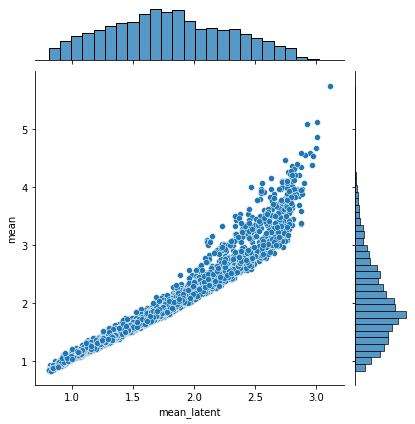

In [80]:
sns.jointplot(data=pred_params, x="mean_latent", y="mean")

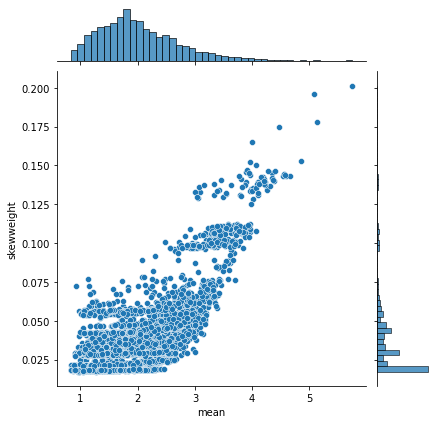

In [69]:
sns.jointplot(data=pred_params, x="mean", y="skewweight")

<Axes: xlabel='mean'>

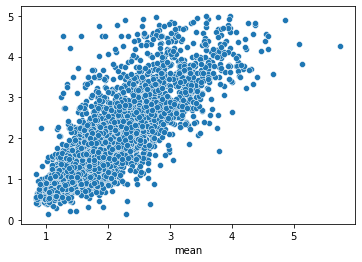

In [70]:
sns.scatterplot(x=pred_params["mean"], y=y_test)

# SHAP Interpretability

[10:11:50] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


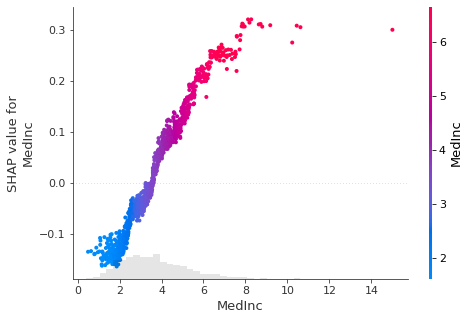

In [71]:
# Partial Dependence Plot
pdp_df = pd.DataFrame(X_train, columns=feature_names)
xgblss.plot(pdp_df.sample(1000, random_state=42),
            parameter="concentration",
            feature=feature_names[0],
            plot_type="Partial_Dependence")

[10:11:56] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


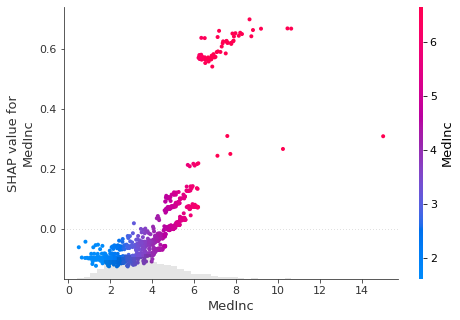

In [72]:
xgblss.plot(pdp_df.sample(1000, random_state=42),
            parameter="skewweight",
            feature=feature_names[0],
            plot_type="Partial_Dependence")

[10:12:01] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


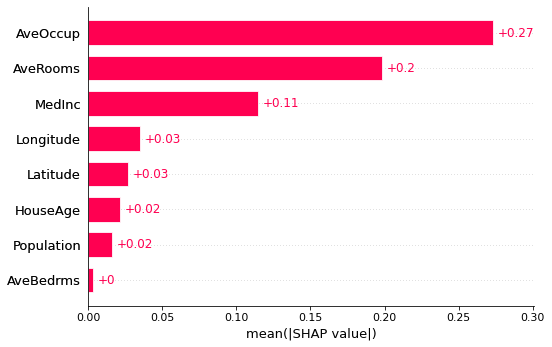

In [74]:
# Feature Importance
xgblss.plot(pdp_df.sample(1000, random_state=42),
            parameter="skewweight",
            plot_type="Feature_Importance")

[10:12:32] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


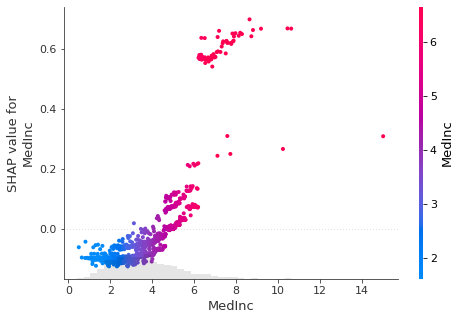

In [78]:
xgblss.plot(pdp_df.sample(1000, random_state=42),
            parameter="skewweight",
            feature="MedInc",
            plot_type="Partial_Dependence")